In [46]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [2]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

weights_fpath = '../dat/sim/cnn_counts_predictor.pt'
test_data_fpath = '../dat/sim/test_labels.csv'
raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000

In [3]:
model = CountsRegressor(n_conv_layers,
    n_dense_layers,
    n_outputs,
    sequence_length,
    filters,
    filter_width,
    dense_layer_width
)
model.load_state_dict(torch.load(weights_fpath))
model

CountsRegressor(
  (conv_layers): Sequential(
    (0): Conv1d(4, 15, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (7): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (dense_layers): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1230, out_features=30, bias=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU()
    (5): Linear(in_features=30, out_features=30, bias=True)
    (6): ReLU()
  )
  (regressor): Linear(in_features=30, out_features=2, bias=True)
)

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

In [4]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

In [5]:
predictions, losses, metrics = run_one_epoch(
    model, test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "pearson-r": pearson_r,
    }
)
metrics

{'spearman-rho': [0.8769130964523633, 0.8548859212413088],
 'pearson-r': [0.8857618421064726, 0.900948054089068]}

In [6]:
np.array(predictions).shape

(10000, 2)

Text(0, 0.5, 'Actual exposure counts')

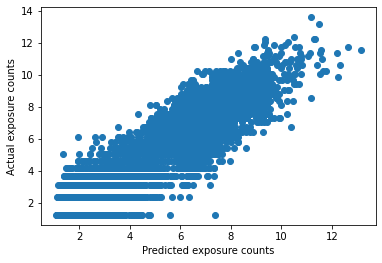

In [7]:
plt.scatter(np.array(predictions)[:, 0], anscombe_transform(test_df[label_cols[0]]))
plt.xlabel("Predicted exposure counts")
plt.ylabel("Actual exposure counts")

Text(0, 0.5, 'Actual outcome counts')

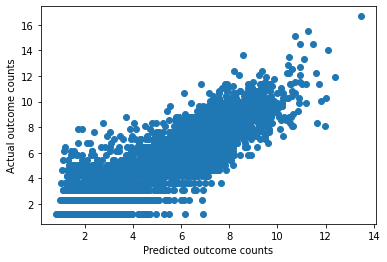

In [8]:
plt.scatter(np.array(predictions)[:, 1], anscombe_transform(test_df[label_cols[1]]))
plt.xlabel("Predicted outcome counts")
plt.ylabel("Actual outcome counts")

# Testing Interaction Effects
So we see that the model predicts both sets of outputs quite well. Now, we want to understand whether the models capture the _interaction effects_ as defined by Finkelstein and Shrikumar et al.

Finkelstein et al define an interaction effect as follows. Let $ s_{GT} $ denote a sequence containing strong matches for both motifs of interest (in our case, the GATA and TAL1 motifs). Then, let $ s_{T} $ denote the result of knocking out the GATA motif from $ s_{GT} $, and $ s_{G} $ the analogous result but for the TAL1 motif. Finally, let $ s_{\emptyset} $ denote the result of knocking out both motifs. Denoting our model as $ f $, the TAL1 motif's per-sequence main effect contribution $ M_T $ is $ f(s_{GT}) - f(s_{G}) $ and GATA's $ M_G $ is $ f(s_{GT}) - f(s_{T}). $ The joint effect contribution is $ J_{G, T} = f(s_{GT}) - f(s_{\emptyset}). $ The interaction effect $ I_{G, T} = J_{G, T} - (M_{G} + M_{T}). $

In Shrikumar et al, all effects are computed in raw counts space. Here, for purposes of making our result relevant to Deep MR, we compute interaction effects in both Anscombe-transformed space and raw counts space but focus on the validity of the former.

In [9]:
original_simulation_df = pd.read_csv(raw_simulation_data_fpath, sep="\t")
original_simulation_df.head()

,seqName,sequence,embeddings,has_exposure,has_outcome,has_both
0,test-synth50000,GGTCTTTGAATTCATATACCCAAGTGTGGGCACCGCTAGTAACAGG...,"pos-81_GATA_disc1-ACTGATAAGC,pos-37_TAL1_known...",1,1,1
1,test-synth50001,CACGACGAGATTCGGGAGAATGAGACAACCCGTCATCTCCACTCCT...,NaN,0,0,0
2,test-synth50002,TTGCGCTAGATAAGCTCACACTGCTCAGTAGAACTATGAACTGGGA...,pos-5_GATA_disc1-CTAGATAAGC,1,0,1
3,test-synth50003,AGTTAAGATGCGACCGATTTTGCTTTCTTGGGCTGTGCATAAATGG...,NaN,0,0,0
4,test-synth50004,GTAGCTATCACCCCATTAACGTTCCGGGCGTGCGCTTGACAAGCTA...,pos-44_GATA_disc1-TACGATAAGA,1,0,1


In [10]:
merged_data_df = original_simulation_df.merge(test_df, left_on="sequence", right_on="sequences")
merged_data_df.head()

,seqName,sequence,embeddings,has_exposure,has_outcome,has_both,sequences,labels_exp,labels_out
0,test-synth50000,GGTCTTTGAATTCATATACCCAAGTGTGGGCACCGCTAGTAACAGG...,"pos-81_GATA_disc1-ACTGATAAGC,pos-37_TAL1_known...",1,1,1,GGTCTTTGAATTCATATACCCAAGTGTGGGCACCGCTAGTAACAGG...,7,6
1,test-synth50001,CACGACGAGATTCGGGAGAATGAGACAACCCGTCATCTCCACTCCT...,NaN,0,0,0,CACGACGAGATTCGGGAGAATGAGACAACCCGTCATCTCCACTCCT...,16,0
2,test-synth50002,TTGCGCTAGATAAGCTCACACTGCTCAGTAGAACTATGAACTGGGA...,pos-5_GATA_disc1-CTAGATAAGC,1,0,1,TTGCGCTAGATAAGCTCACACTGCTCAGTAGAACTATGAACTGGGA...,15,0
3,test-synth50003,AGTTAAGATGCGACCGATTTTGCTTTCTTGGGCTGTGCATAAATGG...,NaN,0,0,0,AGTTAAGATGCGACCGATTTTGCTTTCTTGGGCTGTGCATAAATGG...,0,0
4,test-synth50004,GTAGCTATCACCCCATTAACGTTCCGGGCGTGCGCTTGACAAGCTA...,pos-44_GATA_disc1-TACGATAAGA,1,0,1,GTAGCTATCACCCCATTAACGTTCCGGGCGTGCGCTTGACAAGCTA...,14,0


In [11]:
both_motifs_df = merged_data_df[(merged_data_df['has_exposure'] == 1) & (merged_data_df['has_outcome'] == 1)]
exposure_motif_df = merged_data_df[merged_data_df['has_exposure'] == 1]
outcome_motif_df = merged_data_df[merged_data_df['has_outcome'] == 1]
neither_motif_df = merged_data_df[
    (merged_data_df['has_exposure'] == 0) & (merged_data_df['has_outcome'] == 0)
]

In [12]:
len(both_motifs_df), len(exposure_motif_df), len(outcome_motif_df), len(neither_motif_df)

(2488, 5029, 4990, 2469)

In [13]:
nts = list(background_frequency.keys())
background_probs = list(background_frequency.values())

def knock_out_motifs(sequence, knock_out_targets):
    knocked_out_sequence = sequence
    for knock_out_target in knock_out_targets:
        replacement_sequence = np.random.choice(
            nts, p=background_probs, size=len(knock_out_target["motif_string"])
        )
        replacement_sequence = "".join(replacement_sequence)
        knock_out_start = knock_out_target["start_position"]
        knock_out_end = knock_out_start + len(knock_out_target["motif_string"])
        knocked_out_sequence = (
            knocked_out_sequence[:knock_out_start] +
            replacement_sequence +
            knocked_out_sequence[knock_out_end:]
        )
    
    assert len(knocked_out_sequence) == len(sequence), (len(knocked_out_sequence), len(sequence))
    return knocked_out_sequence

def generate_knocked_out_sequences(sequences_df, exposure_name="GATA", outcome_name="TAL1"):
    exposure_knock_outs = []
    outcome_knock_outs = []
    both_knock_outs = []
    for row in sequences_df.iterrows():
        sequence = row[1]['sequence']
        embedding_info = [embedding.split("_") for embedding in row[1]["embeddings"].split(",")]
        knock_out_targets = {}
        for embedding in embedding_info:
            knock_out_target = {}
            knock_out_target["start_position"] = int(embedding[0].split("-")[1]) # format 'pos-<start position>'
            knock_out_target["motif_type"] = embedding[1]
            knock_out_target["motif_string"] = embedding[2].split("-")[1] # format '<motif name>-<string>'
            assert embedding[1] in (exposure_name, outcome_name)
            knock_out_targets[embedding[1]] = knock_out_target
            
        assert len(knock_out_targets) == 2, len(knock_out_targets) 

        exposure_knock_outs.append(knock_out_motifs(sequence, [knock_out_targets[exposure_name]]))
        outcome_knock_outs.append(knock_out_motifs(sequence, [knock_out_targets[outcome_name]]))
        both_knock_outs.append(knock_out_motifs(sequence, knock_out_targets.values()))
    return exposure_knock_outs, outcome_knock_outs, both_knock_outs

In [23]:
exposure_knock_outs, outcome_knock_outs, both_knock_outs = generate_knocked_out_sequences(both_motifs_df)
both_motifs_df['sequence_exp_knock_out'] = exposure_knock_outs
both_motifs_df['sequence_out_knock_out'] = outcome_knock_outs
both_motifs_df['sequence_both_knock_out'] = both_knock_outs
clear_output();

In [31]:
unperturbed_dataset = IterablePandasDataset(
    both_motifs_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
unperturbed_data_loader = torch.utils.data.DataLoader(
    unperturbed_dataset, batch_size=batch_size, num_workers=0
)

exposure_knock_out_dataset = IterablePandasDataset(
    both_motifs_df, x_cols="sequence_exp_knock_out", y_cols=label_cols, x_transform=one_hot,
)
exposure_knock_out_data_loader = torch.utils.data.DataLoader(
    exposure_knock_out_dataset, batch_size=batch_size, num_workers=0
)

outcome_knock_out_dataset = IterablePandasDataset(
    both_motifs_df, x_cols="sequence_out_knock_out", y_cols=label_cols, x_transform=one_hot,
)
outcome_knock_out_data_loader = torch.utils.data.DataLoader(
    outcome_knock_out_dataset, batch_size=batch_size, num_workers=0
)

both_knock_out_dataset = IterablePandasDataset(
    both_motifs_df, x_cols="sequence_both_knock_out", y_cols=label_cols, x_transform=one_hot,
)
both_knock_out_data_loader = torch.utils.data.DataLoader(
    both_knock_out_dataset, batch_size=batch_size, num_workers=0
)

In [33]:
len(unperturbed_dataset), len(exposure_knock_out_dataset)

(2488, 2488)

In [34]:
unperturbed_preds, _, _ = run_one_epoch(model, unperturbed_data_loader, None, training=False, metrics_config={})
exposure_knock_out_preds, _, _ = run_one_epoch(
    model, exposure_knock_out_data_loader, None, training=False, metrics_config={}
)
outcome_knock_out_preds, _, _ = run_one_epoch(
    model, outcome_knock_out_data_loader, None, training=False, metrics_config={}
)
both_knock_out_preds, _, _ = run_one_epoch(
    model, both_knock_out_data_loader, None, training=False, metrics_config={}
)
unperturbed_preds = np.array(unperturbed_preds)
exposure_knock_out_preds = np.array(exposure_knock_out_preds)
outcome_knock_out_preds = np.array(outcome_knock_out_preds)
both_knock_out_preds = np.array(both_knock_out_preds)

In [35]:
len(unperturbed_preds)

2488

In [42]:
main_effs_exp = outcome_knock_out_preds - both_knock_out_preds
main_effs_out = exposure_knock_out_preds - both_knock_out_preds
joint_effs = unperturbed_preds - both_knock_out_preds
interaction_effs = joint_effs - (main_effs_exp + main_effs_out)

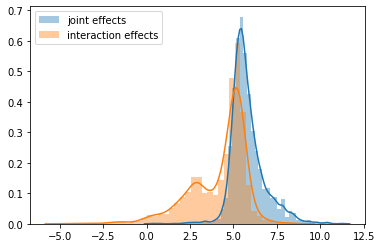

In [51]:
sns.distplot(joint_effs[:, 1], label="joint effects")
sns.distplot(interaction_effs[:, 1], label="interaction effects")
plt.legend();

In [ ]:
n_seqs = sample_seqs.shape
preds = {}
for seq in tqdm(sample_seqs):
    muts = generate_wt_mut_batches(seq.T, seq.shape[0] * seq.shape[1]).squeeze()
    preds_ = model.predict(muts.transpose(0, 2, 1))
    for key, value in preds_.items():
        if key in cols:
            preds.setdefault(key, []).append(preds_[key])